## Evaluating regression techniques for speaker characterization
### Laura Fernández Gallardo

Multioutput regression: for each instance, targeting the prediction of the 5 dimensions of perceptive speaker characteristics.

Motifications with respect to regression with 1-dimensional output:

* targets: 5-dimensional scores derived from factor analysis on the 34-dimensional ratings of speaker characteristics in the [subjective analysis](https://github.com/laufergall/Subjective_Speaker_Characteristics).


In [1]:
import io
import requests

import numpy as np
import pandas as pd

from reg_tuning import * # my helper functions

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

In [3]:
# features and ratings from the regression task with 1d output

feats_ratings_train = pd.read_csv(r'.\data_while_tuning\feats_ratings_train.csv')
feats_ratings_test = pd.read_csv(r'.\data_while_tuning\feats_ratings_test.csv')

sc_names = ['non_likable', 'secure', 'attractive', 'unsympathetic', 'indecisive', 'unobtrusive', 'distant', 'bored', 'emotional', 'not_irritated', 'active', 'pleasant', 'characterless', 'sociable', 'relaxed', 'affectionate', 'dominant', 'unaffected', 'hearty', 'old', 'personal', 'calm', 'incompetent', 'ugly', 'friendly', 'masculine', 'submissive', 'indifferent', 'interesting', 'cynical', 'artificial', 'intelligent', 'childish', 'modest']

dropcolumns = ['name','spkID','speaker_gender'] + sc_names
feats_names = list(feats_ratings_train.drop(dropcolumns, axis=1))

In [4]:
# speaker scores

path = "https://raw.githubusercontent.com/laufergall/Subjective_Speaker_Characteristics/master/data/generated_data/"

url = path + "factorscores_malespk.csv"
s = requests.get(url).content
scores_m =pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "factorscores_femalespk.csv"
s = requests.get(url).content
scores_f =pd.read_csv(io.StringIO(s.decode('utf-8')))

# rename dimensions
scores_m.columns = ['sample_heard', 'warmth', 'attractiveness', 'confidence', 'compliance', 'maturity']
scores_f.columns = ['sample_heard', 'warmth', 'attractiveness', 'compliance', 'confidence', 'maturity']

# join male and feame scores
scores = scores_m.append(scores_f)
scores['gender'] = scores['sample_heard'].str.slice(0,1)
scores['spkID'] = scores['sample_heard'].str.slice(1,4).astype('int')

scores.head()

,attractiveness,compliance,confidence,maturity,sample_heard,warmth,gender,spkID
0,-0.579301,-0.921918,0.608503,0.276580,m004_linden_stimulus.wav,-0.284638,m,4
1,0.442865,-0.950212,0.588889,0.630295,m005_nicosia_stimulus.wav,-0.494019,m,5
2,-0.507534,0.139302,-0.151077,-0.669449,m006_rabat_stimulus.wav,1.533478,m,6
3,1.180748,-0.108982,0.962166,1.026359,m007_klaksvik_stimulus.wav,0.478983,m,7
4,1.070247,-0.284278,-0.875589,-1.291311,m016_beirut_stimulus.wav,1.861551,m,16


In [5]:
# merge scores and features

feats_ratings_scores_train = feats_ratings_train.merge(scores) # (2700, 132)
feats_ratings_scores_test = feats_ratings_test.merge(scores) # (891, 132)

# drop unnecessary columns
feats_ratings_scores_train = feats_ratings_scores_train.drop(['speaker_gender','sample_heard'] + sc_names, axis = 1)
feats_ratings_scores_test = feats_ratings_scores_test.drop(['speaker_gender','sample_heard'] + sc_names, axis = 1)

# 'name' + 88 features + 5 traits + 'gender' + 'spkID'
# shape train: (2700, 96), shape test: (891, 96) 

In [6]:
# Standardize speech features  

dropcolumns = ['name','gender','spkID'] + list(scores_m.columns)[1:]

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_ratings_scores_train.drop(dropcolumns, axis=1))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_ratings_scores_train.drop(dropcolumns, axis=1))
feats_s_test = scaler.transform(feats_ratings_scores_test.drop(dropcolumns, axis=1)) 

## Model tuning with feature selection

Use the train data to find the classifier and its hyperparameters leading to the best performance. 

Not performing feature selection with "SelectKBest": Univariate feature selection does not support multilabel. 

In [7]:
# training data. Features and labels
X = feats_s_train # (2700, 88)
y = feats_ratings_scores_train[['warmth','attractiveness']].as_matrix() # (2700, 2)

# test data. Features and labels
Xt = feats_s_test # (891, 88)
yt = feats_ratings_scores_test[['warmth','attractiveness']].as_matrix() # (891, 2)

# split train data into 80% and 20% subsets - with balance in trait and gender
# give subset A to the inner hyperparameter tuner
# and hold out subset B for meta-evaluation
AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_ratings_scores_train['gender'], random_state=2302)

print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
print('Number of instances in B (meta-evaluation):',BX.shape[0])

Number of instances in A (hyperparameter tuning): 2160
Number of instances in B (meta-evaluation): 540


In [3]:
# dataframe with results from hp tuner to be appended
tuning_all = pd.DataFrame()

# list with tuned classifiers trained on training data, to be appended
trained_all = []

In [9]:
# save splits

# original features and class
feats_ratings_scores_train.to_csv(r'.\data_while_tuning\feats_ratings_scores_train.csv', index=False)
feats_ratings_scores_test.to_csv(r'.\data_while_tuning\feats_ratings_scores_test.csv', index=False)

# train/test partitions, features and labels
np.save(r'.\data_while_tuning\X_multioutput_WAAT.npy', X)
np.save(r'.\data_while_tuning\y_multioutput_WAAT.npy', y)
np.save(r'.\data_while_tuning\Xt_multioutput_WAAT.npy', Xt)
np.save(r'.\data_while_tuning\yt_multioutput_WAAT.npy', yt)

# # A/B splits, features and labels
np.save(r'.\data_while_tuning\AX_multioutput_WAAT.npy', AX)
np.save(r'.\data_while_tuning\BX_multioutput_WAAT.npy', BX)
np.save(r'.\data_while_tuning\Ay_multioutput_WAAT.npy', Ay)
np.save(r'.\data_while_tuning\By_multioutput_WAAT.npy', By)

### Calling hp_tuner() for each classifier

** Recover ** when new ipynb session started.

(Workaround for working with hyperparameter tuning during several days)

In [4]:
# original features and class
feats_ratings_scores_train = pd.read_csv(r'.\data_while_tuning\feats_ratings_scores_train.csv')
feats_ratings_scores_test = pd.read_csv(r'.\data_while_tuning\feats_ratings_scores_test.csv')
feats_names = pd.read_csv(r'.\data_while_tuning\feats_names.csv', header=None)
feats_names = feats_names.values.tolist()

# train/test partitions, features and labels
X = np.load(r'.\data_while_tuning\X_multioutput_WAAT.npy')
y = np.load(r'.\data_while_tuning\y_multioutput_WAAT.npy')
Xt = np.load(r'.\data_while_tuning\Xt_multioutput_WAAT.npy')
yt = np.load(r'.\data_while_tuning\yt_multioutput_WAAT.npy')

# A/B splits, features and labels
AX = np.load(r'.\data_while_tuning\AX_multioutput_WAAT.npy')
BX = np.load(r'.\data_while_tuning\BX_multioutput_WAAT.npy')
Ay = np.load(r'.\data_while_tuning\Ay_multioutput_WAAT.npy')
By = np.load(r'.\data_while_tuning\By_multioutput_WAAT.npy')


In [ ]:
# Loading outpus of hp tuning from disk
tuning_all, trained_all = load_tuning('multioutput_WAAT')

Call this after each experiment **to recover later**: 

In [8]:
# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all, 'multioutput_WAAT')

#### Decision tree

*class sklearn.tree.DecisionTreeRegressor(criterion=’mse’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, presort=False)*

Tune: max_depth

In [5]:
from sklearn.tree import DecisionTreeRegressor

"""
Decision Trees
"""
def get_DecisionTreeRegressor2tune():
    
    model = DecisionTreeRegressor()
    hp = dict(
        regressor__estimator__max_depth = np.arange(2,20) 
    )
    return 'DecisionTreeRegressor', model, hp


# tune this model (multiputput)
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_DecisionTreeRegressor2tune], 
                           'multioutput_WAAT',
                           feats_names,
                           [88], # feature selection not performed
                           mode='random',
                           n_iter=10
                          )

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'DecisionTreeRegressor' -> Best cross-val score on A set: -2.060822 using {'regressor__estimator__max_depth': 3}
'DecisionTreeRegressor' -> root mean_squared_error on B set: 1.442424



#### Random Forest

*class sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)*

Tune: max_features, max_depth, min_samples_leaf

In [6]:
from sklearn.ensemble import RandomForestRegressor

"""
Random Forest
"""
def get_RandomForestRegressor2tune():
    
    model = DecisionTreeRegressor()
    hp = dict(
        regressor__estimator__max_features = np.arange(2,50),
        regressor__estimator__max_depth = np.arange(2,50), 
        regressor__estimator__min_samples_leaf = np.arange(2,100) 
    )
    return 'RandomForestRegressor', model, hp


# tune this model (multiputput)
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_RandomForestRegressor2tune], 
                           'multioutput_WAAT',
                           feats_names,
                           [88], # feature selection not performed
                           mode='random',
                           n_iter=50
                          )

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'RandomForestRegressor' -> Best cross-val score on A set: -1.945889 using {'regressor__estimator__min_samples_leaf': 54, 'regressor__estimator__max_features': 31, 'regressor__estimator__max_depth': 14}
'RandomForestRegressor' -> root mean_squared_error on B set: 1.417873



## Testing

### RMSE
Testing the best model found after hyperparameter tuning.

Performance metric: RMSE (see above).
    
The predictions correspond to the scores of each test segment (3 parts x 4 dialogs) spoken by the same test speaker. I perform the average of the predicted scores that correspond to the same speaker - to be compared to the true scores.

In [10]:
# select the classifier that gave the maximum acc on B set
best_accs = tuning_all['best_accs']
i_best = best_accs.idxmin()

print('Selected classifier based on the best performance on B: %r (perf. on B = %0.2f)' % (tuning_all.loc[i_best,'regressors_names'], round(best_accs[i_best],2)))

Selected classifier based on the best performance on B: 'RandomForestRegressor' (perf. on B = 1.42)


In [11]:
# compute predictions with the best tuned regressor

yt_pred = trained_all[i_best][0].predict(Xt)


In [14]:
# average of outputs that belong to the same speaker

test_scores = pd.DataFrame(data = feats_ratings_scores_test[['warmth','attractiveness','spkID']])
test_scores['warmth_pred'] = yt_pred[:, 0]
test_scores['attractiveness_pred'] = yt_pred[:, 1]

test_scores_avg = test_scores.groupby('spkID').mean()

myrmse_avg = np.sqrt(mean_squared_error(test_scores_avg[['warmth','attractiveness']].as_matrix(), 
             test_scores_avg[['warmth_pred','attractiveness_pred']].as_matrix()))
    
print('RMSE after averaging over speaker utterances: %0.2f' % myrmse_avg)    

RMSE after averaging over speaker utterances: 1.50


### Visualization

1) WAAT scores of test data and averaged predicted test data.

2) animation (.html) of pairs of true-predicted WAAT scores. For each frame i, 2 points are plotted in 2D: one corresponding to the true WAAT of speaker i and the other one corresponding to the averaged predicted WAAT of the same speaker.

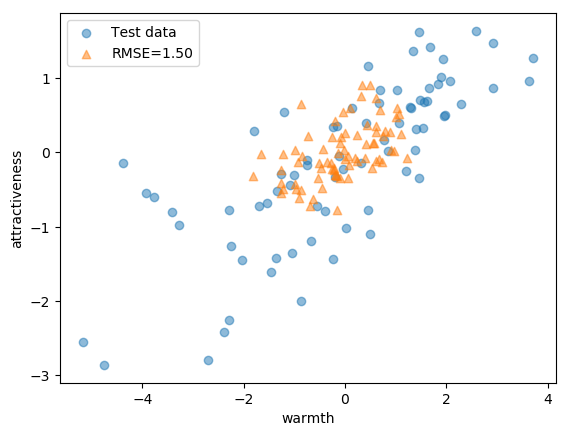

In [15]:
plt.style.use(['default'])
alpha = 0.5

plt.figure()
# plt.scatter(y[:, 0], y[:, 1],
#             marker="o", alpha=alpha, label="Train data")
plt.scatter(test_scores_avg['warmth'], test_scores_avg['attractiveness'],
            marker="o", alpha=alpha, label="Test data")
plt.scatter(test_scores_avg['warmth_pred'], test_scores_avg['attractiveness_pred'],
            marker="^", alpha=alpha,
            label="RMSE=%.2f" % myrmse_avg)

plt.xlabel('warmth')
plt.ylabel('attractiveness')

plt.legend()

# save figure
filename = r'\multioutput_test_'+tuning_all.loc[i_best,'regressors_names']+'.png'
plt.savefig(r'.\figures' + filename, bbox_inches = 'tight')  

In [16]:
test_scores_avg.reset_index(inplace=True)
true_scores = test_scores_avg[['spkID','warmth','attractiveness']]
true_scores['type']='true'
pred_scores = test_scores_avg[['spkID','warmth_pred','attractiveness_pred']].rename(index=str, 
                                                                                    columns={"warmth_pred": "warmth", 
                                                                                             "attractiveness_pred": "attractiveness"})
pred_scores['type']='pred'
test_scores_avg_WAAT = true_scores.append(pred_scores)

D:\Users\fernandez.laura\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


D:\Users\fernandez.laura\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\animation.py:1218: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


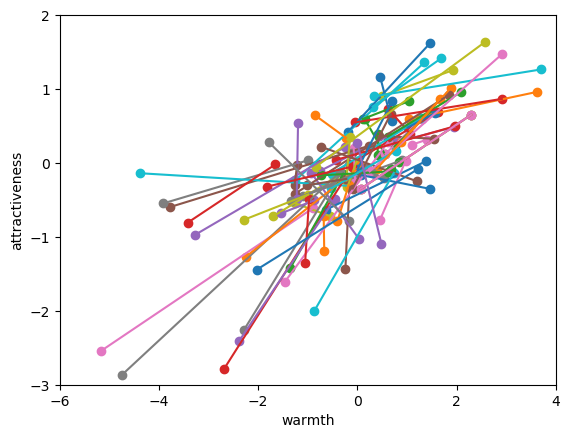

In [17]:
from matplotlib.animation import FuncAnimation

unique_speakers = test_scores_avg_WAAT['spkID'].unique()

fig, ax = plt.subplots()

# Plot a scatter that persists(isn't redrawn) 
ax.set_xlabel('warmth')
ax.set_ylabel('attractiveness')
ax.set_xlim(-6, 4)  
ax.set_ylim(-3, 2)        

def update(i):
    spk=unique_speakers[i]
    coor_x = test_scores_avg_WAAT.loc[test_scores_avg_WAAT['spkID']==spk,'warmth']
    coor_y = test_scores_avg_WAAT.loc[test_scores_avg_WAAT['spkID']==spk,'attractiveness']
    ax.scatter(coor_x, coor_y)
    ax.plot(coor_x, coor_y) 
    return ax

# create animation
anim = FuncAnimation(fig, update, frames=np.arange(0, len(unique_speakers)), interval=200)

# # save animation
# filename = r'\multioutput_test_'+tuning_all.loc[i_best,'regressors_names']+'.html'
# anim.save(r'.\figures' + filename, dpi=80, writer='imagemagick')


TODO

* tune to reduce RMSE
* output RMSE for warmth and for attractiveness separately

* same for the 5 traits